(891, 16) (418, 16)
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8181532860460738
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8372606867114432
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8305191136777352
****
Tuned Random Forest Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 7}
Best score is 0.8282593685267718


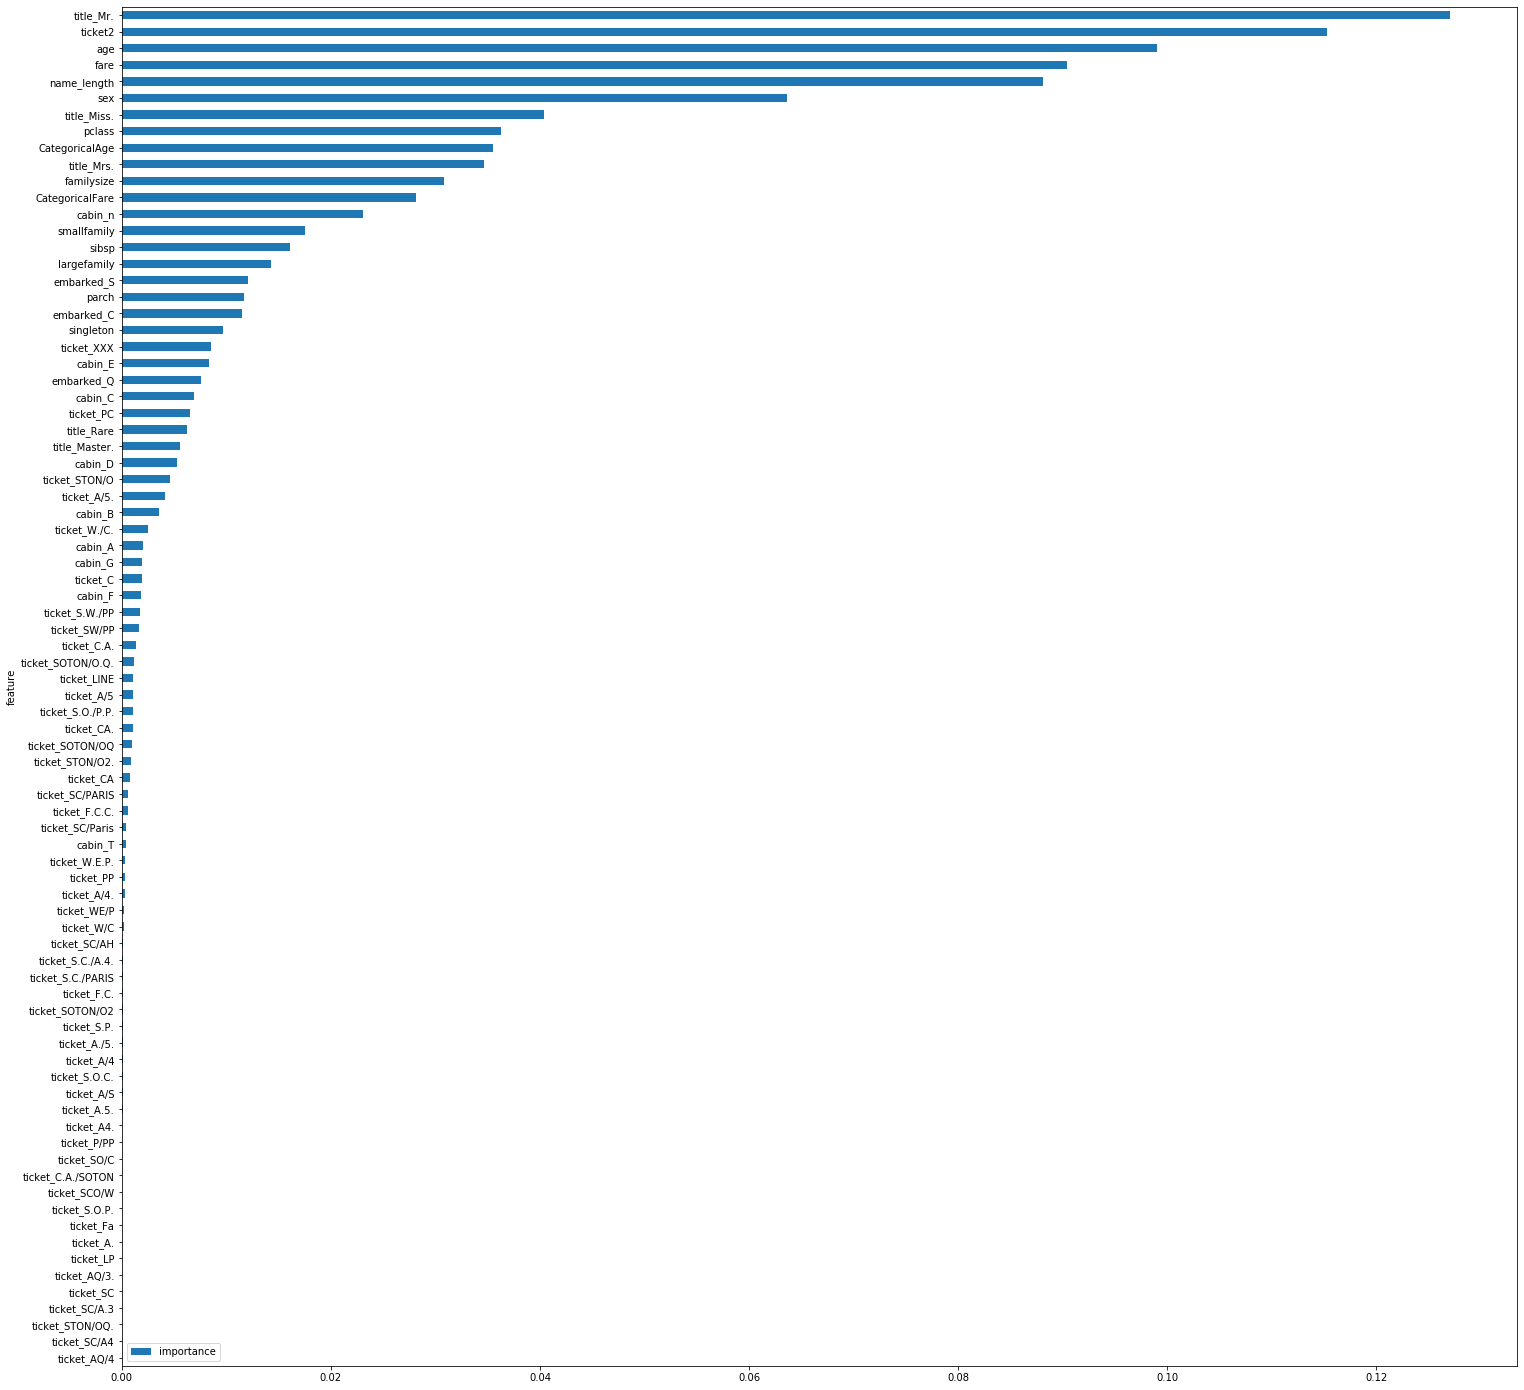

In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re

# Feature Engineering

def  get_combined_data_title ():
    global y,train_objs_num,train,data,test
    # reading train data
    train = pd.read_csv('C:/Users/bagchi/Downloads/train.csv')
    train.columns = [c.lower() for c in train.columns]

    # reading test data
    test = pd.read_csv('C:/Users/bagchi/Downloads/test.csv')
    test.columns = [c.lower() for c in test.columns]

    # extracting and then removing the targets from the training data 
    y = train.survived
    #train.drop(columns =[ 'survived'], inplace=True)
    
    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    train_objs_num = len(train)
    data = pd.concat(objs=[train, test], axis=0)
    #data.reset_index(inplace=True)
    data.drop(['survived', 'passengerid'], inplace=True, axis=1)
    
    # Feature engineer Name
    data['name_length'] = data['name'].apply(len)
    data['title'] = data['name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(0))
    #print(data.title.value_counts())
    l = ['Miss.','Master.','Mr.','Mrs.']
    data['title'] = data['title'].replace('Mlle.', 'Miss.')
    data['title'] = data['title'].replace('Ms.', 'Miss.')
    data['title'] = data['title'].replace('Mme.', 'Mrs.')
    data['title'] = data['title'].apply(lambda x: 'Rare' if x not in l else x)
    return data

data = get_combined_data_title ()


#print('Number of missing ages in train set:',data[:train_objs_num].age.isnull().sum())
#print('Number of missing ages in test set:',data[train_objs_num:].age.isnull().sum())

grouped_train = data[:train_objs_num].groupby(['sex','pclass','title']).mean()
grouped_mean_train = grouped_train.reset_index()[['sex', 'pclass', 'title', 'age']]
grouped_train = data[:train_objs_num].groupby(['sex','pclass','title']).std()
grouped_std_train = grouped_train.reset_index()[['sex', 'pclass', 'title', 'age']]
#print(len(grouped_mean_train))
#print(len(data[train_objs_num:]))
def fill_age(row):
    condition = (
        (grouped_mean_train['sex'] == row['sex']) & 
        (grouped_mean_train['title'] == row['title']) & 
        (grouped_mean_train['pclass'] == row['pclass'])
    ) 
    from random import randrange, uniform
    return uniform(grouped_mean_train[condition]['age'].values[0]-grouped_std_train[condition]['age'].values[0],grouped_mean_train[condition]['age'].values[0]+grouped_std_train[condition]['age'].values[0])

def process_age():
    global data
    # a function that fills the missing values of the Age variable
    data['age'] = data.apply(lambda row: fill_age(row) if np.isnan(row['age']) else row['age'], axis=1)
    return data

data = process_age()

def process ():
    global data
    # there's one missing fare value - replacing it with the mean.
    data.fare.fillna(data[:train_objs_num].fare.mean(), inplace=True)
    data.embarked.fillna(data[:train_objs_num].embarked.mode()[0], inplace=True)
    data['sex'] = data['sex'].apply(lambda x: 1 if x=='male' else 0)
    ##alternative for cabin
    '''data['no_cabin'] = data.cabin.isnull().astype(int)
    data.drop(columns =['cabin'], inplace=True)'''
    data.cabin.fillna(data[:train_objs_num].cabin.mode(), inplace=True)
    # mapping each Cabin value with the cabin letter
    data['cabin'] = data['cabin'].map(lambda c: str(c)[0])
    # introducing a new feature : the size of families (including the passenger)
    data['familysize'] = data['parch'] + data['sibsp'] + 1
    # introducing other features based on the family size
    data['singleton'] = data['familysize'].apply(lambda s: 1 if s == 1 else 0)
    data['smallfamily'] = data['familysize'].apply(lambda s: 1 if 2 <= s <= 4 else 0)
    data['largefamily'] = data['familysize'].apply(lambda s: 1 if 5 <= s else 0)
    return data

data = process()
#print(data.head(20))
# So as to extract more info from ticket feature
data['ticket2'] = data.ticket.astype('category').cat.codes

def  process_ticket ():
    global data
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        #ticket = ticket.replace('.','')
        #ticket = ticket.replace('/','')
        ticket = ticket.split()
        #ticket = map(lambda t : t.strip(), ticket)
        #ticket = filter(lambda t : not t.isdigit(), ticket)
        if ticket[0].isdigit():
            return 'XXX'
        else:
            return ticket[0]
    
    # Extracting dummy variables from tickets:

    data['ticket'] = data['ticket'].map(cleanTicket)
    return data

data = process_ticket()


def drop_dummy ():
    global data
    #drop
    data.drop(columns = ['name'],inplace=True)
    data = pd.get_dummies(data)
    return data

data = drop_dummy ()

#Slighlty imporve the model: qcut, the bins will be chosen so that you have the same number of records in each bin.:
# while cut unequal 
data['CategoricalAge'] = pd.cut(data['age'], 5).astype('category').cat.codes
data['CategoricalFare'] = pd.qcut(data['fare'], 4).astype('category').cat.codes
data.head()

# Feature selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(data[:train_objs_num], y)


features = pd.DataFrame()
features['feature'] = data.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(data[:train_objs_num])
test_reduced = model.transform(data[train_objs_num:])
print(train_reduced.shape,test_reduced.shape)


from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


logreg = LogisticRegression()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, rf, gboost]
cross_validation = StratifiedKFold(n_splits=5,random_state=50)

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = np.mean(cross_val_score(model, data[:train_objs_num], y, cv = cross_validation, scoring='accuracy'))
    print('CV score = {0}'.format(score))
    print('****')


from sklearn.model_selection import RandomizedSearchCV
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8]}

rfc_cv = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, cv= cross_validation, n_iter=25)
rfc_cv.fit(data[:train_objs_num], y)

# Print the tuned parameter and score
print("Tuned Random Forest Parameters: {}".format(rfc_cv.best_params_))
print("Best score is {}".format(rfc_cv.best_score_))

predictions = rfc_cv.predict(data[train_objs_num:])
submission = pd.DataFrame({ 'PassengerId': test.passengerid,
                            'Survived': predictions })
submission.to_csv("C:/Users/bagchi/Downloads/submission.csv", index=False)
#submission.head()

